In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, recall_score, accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier


In [2]:
#importing the data 
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

# Data Preparation

In [3]:
#inspecting customer datasets 
print("Customers")
print(customers.head())
print("\n")
print(customers.count())
print("\n")
print(customers.describe())


Customers
   customer_id   join_date last_purchase_date   age  gender           location
0            1  2023-11-20         2024-03-17  56.0  Female  North Shannonbury
1            2  2021-09-08         2023-10-25   NaN    Male          Hillville
2            3  2021-06-01         2022-11-27   NaN     NaN   North Latoyatown
3            4  2022-01-01         2022-09-01  29.0    Male          Grossstad
4            5  2022-01-24         2023-06-02   NaN    Male   East Matthewfort


customer_id           10000
join_date             10000
last_purchase_date    10000
age                    8991
gender                 9467
location              10000
dtype: int64


       customer_id          age
count  10000.00000  8991.000000
mean    5000.50000    43.467467
std     2886.89568    15.094380
min        1.00000    18.000000
25%     2500.75000    30.000000
50%     5000.50000    44.000000
75%     7500.25000    57.000000
max    10000.00000    69.000000


In [4]:
# Inspecting the first few rows of the customer dataset
print("Customers")
print(customers.head())
print("\n")

# Counting the number of non-null values in each column of the customer dataset
print(customers.count())
print("\n")

# Generating summary statistics for the numerical columns in the customer dataset
print(customers.describe())

Customers
   customer_id   join_date last_purchase_date   age  gender           location
0            1  2023-11-20         2024-03-17  56.0  Female  North Shannonbury
1            2  2021-09-08         2023-10-25   NaN    Male          Hillville
2            3  2021-06-01         2022-11-27   NaN     NaN   North Latoyatown
3            4  2022-01-01         2022-09-01  29.0    Male          Grossstad
4            5  2022-01-24         2023-06-02   NaN    Male   East Matthewfort


customer_id           10000
join_date             10000
last_purchase_date    10000
age                    8991
gender                 9467
location              10000
dtype: int64


       customer_id          age
count  10000.00000  8991.000000
mean    5000.50000    43.467467
std     2886.89568    15.094380
min        1.00000    18.000000
25%     2500.75000    30.000000
50%     5000.50000    44.000000
75%     7500.25000    57.000000
max    10000.00000    69.000000


In [5]:
# Inspecting the first few rows of the marketing dataset
print("Marketing")
print(marketing.head())
print("\n")

# Counting the number of non-null values in each column of the marketing dataset
print(marketing.count())
print("\n")

# Generating summary statistics for the numerical columns in the marketing dataset
print(marketing.describe())

Marketing
   campaign_id  customer_id response   promotion_type campaign_date
0            1            1       No  Buy One Get One    2024-02-29
1            2            1       No         Discount    2024-01-24
2            3            1       No    Free Shipping    2024-03-05
3            4            1      Yes  Buy One Get One    2024-01-10
4            5            2      Yes    Free Shipping    2022-07-08


campaign_id       25200
customer_id       25200
response          25200
promotion_type    25200
campaign_date     25200
dtype: int64


        campaign_id   customer_id
count  25200.000000  25200.000000
mean   12600.500000   4998.330357
std     7274.757728   2882.991935
min        1.000000      1.000000
25%     6300.750000   2511.000000
50%    12600.500000   5001.000000
75%    18900.250000   7486.000000
max    25200.000000  10000.000000


In [6]:
# Inspecting the first few rows of the transactions dataset
print("Transactions")
print(transactions.head())
print("\n")

# Counting the number of non-null values in each column of the transactions dataset
print(transactions.count())
print("\n")

# Generating summary statistics for the numerical columns in the transactions dataset
print(transactions.describe())

Transactions
   transaction_id  customer_id transaction_date  transaction_amount  \
0               1            1       2024-02-03              165.56   
1               2            1       2024-03-02              699.01   
2               3            1       2024-03-12              146.86   
3               4            1       2024-01-20              927.46   
4               5            1       2024-02-25             1395.87   

  product_category  
0         Clothing  
1       Home Goods  
2       Home Goods  
3      Electronics  
4      Electronics  


transaction_id        129545
customer_id           129545
transaction_date      129545
transaction_amount    129545
product_category      129545
dtype: int64


       transaction_id    customer_id  transaction_amount
count   129545.000000  129545.000000       129545.000000
mean     64773.000000    4998.806237          597.287659
std      37396.564648    2882.049926          491.564174
min          1.000000       1.000000        

In [7]:
# Combining the datasets at the customer level
# Step 1: Aggregating marketing data at the customer level to count the number of positive responses

marketing_agg = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()
marketing_agg.head()

,campaign_id
customer_id,
1,1
2,2
3,1
4,1
6,1


In [8]:
# Step 2: Aggregating transaction data at the customer level
# This aggregates the number of transactions and the total transaction amount for each customer

transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})
transactions_agg.head(10)

,transaction_id,transaction_amount
customer_id,,
1,6,3509.48
2,9,6081.32
3,6,1454.87
4,20,7874.68
5,24,15524.55
6,17,10254.44
7,5,1339.82
8,15,11710.62
9,22,10382.96


In [9]:
# Step 3: Set the index for customers and engagement dataframes as customer_id
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)

In [10]:
# Step 4: Join all tables into a single dataframe
customer_data = customers.join(engagement).join(transactions_agg).join(marketing_agg)

# Inspect the resulting dataframe
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   join_date                10000 non-null  object 
 1   last_purchase_date       10000 non-null  object 
 2   age                      8991 non-null   float64
 3   gender                   9467 non-null   object 
 4   location                 10000 non-null  object 
 5   number_of_site_visits    10000 non-null  int64  
 6   number_of_emails_opened  10000 non-null  int64  
 7   number_of_clicks         10000 non-null  int64  
 8   transaction_id           10000 non-null  int64  
 9   transaction_amount       10000 non-null  float64
 10  campaign_id              7665 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 937.5+ KB


In [11]:
# Transforming dates to datetime format
customer_data['join_date'] = pd.to_datetime(customers['join_date'])
customer_data['last_purchase_date'] = pd.to_datetime(customers['last_purchase_date'])

# Checking to ensure that the date transformation worked
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   join_date                10000 non-null  datetime64[ns]
 1   last_purchase_date       10000 non-null  datetime64[ns]
 2   age                      8991 non-null   float64       
 3   gender                   9467 non-null   object        
 4   location                 10000 non-null  object        
 5   number_of_site_visits    10000 non-null  int64         
 6   number_of_emails_opened  10000 non-null  int64         
 7   number_of_clicks         10000 non-null  int64         
 8   transaction_id           10000 non-null  int64         
 9   transaction_amount       10000 non-null  float64       
 10  campaign_id              7665 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(4), object(2)
memory usage: 937.5+ KB


# Data Preparation

In [12]:
customer_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0


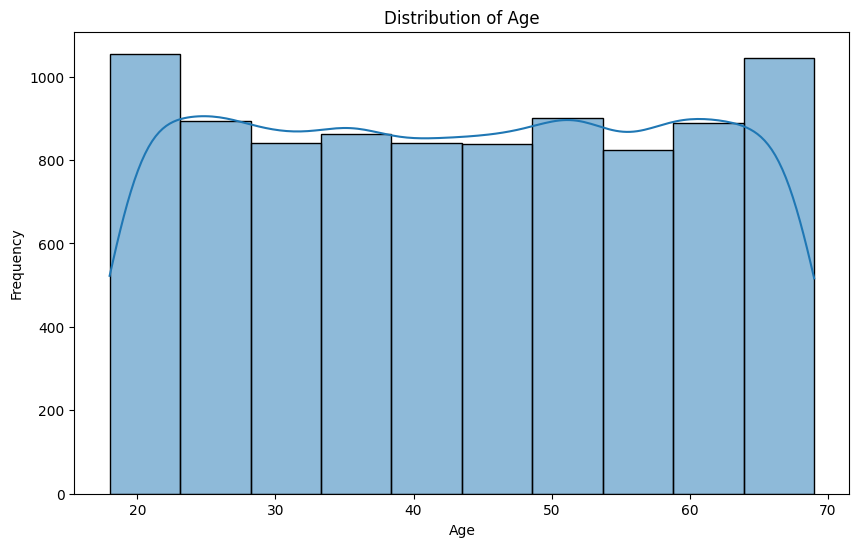

count    8991.000000
mean       43.467467
std        15.094380
min        18.000000
25%        30.000000
50%        44.000000
75%        57.000000
max        69.000000
Name: age, dtype: float64


In [13]:
# Calculate and plot the distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(customer_data['age'].dropna(), bins=10, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Calculate summary statistics for the age column
age_stats = customer_data['age'].describe()
print(age_stats)

In [14]:
# Replacing missing values in the 'age' column with the mean value
customer_data['age'].fillna(customer_data['age'].mean(), inplace=True)


/var/folders/g9/nsrxf98x7b3b8m4gk4095qn80000gn/T/ipykernel_44680/3103058887.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data['age'].fillna(customer_data['age'].mean(), inplace=True)


In [15]:
# Replacing missing values in the 'campaign_id' column with 0
customer_data['campaign_id'].fillna(0, inplace=True)

/var/folders/g9/nsrxf98x7b3b8m4gk4095qn80000gn/T/ipykernel_44680/3977262769.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data['campaign_id'].fillna(0, inplace=True)


In [16]:
# Function to convert gender to categorical values: Female as 1, Male as 2, and missing or other genders as 3
def Gender_Categorical(x):
    if x == 'Female':
        return 1
    elif x == 'Male':
        return 2
    else:
        return 3

# Applying the function to create a new column 'Gender_Categorical'
customer_data['Gender_Categorical'] = customer_data['gender'].apply(Gender_Categorical)

In [17]:
#Finding lifetime value for the customers 

#Finding the end date of the data
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
last_transaction = transactions["transaction_date"].max()
print(last_transaction)


# Calculating the duration of time each customer has been with the company in years
customer_data['age_as_cust'] = ((last_transaction - customer_data['join_date']).dt.days)/365

# Calculating the Annual Lifetime Value (LTV) for each customer
customer_data['LTV'] = customer_data['transaction_amount']/customer_data['age_as_cust']


2024-05-31 00:00:00


In [18]:
#looking at the features of LTV
customer_data['LTV'].describe()

/Users/nicoleimoru/Library/Python/3.9/lib/python/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1.000000e+04
mean              inf
std               NaN
min      7.059829e+00
25%      1.724126e+03
50%      3.513149e+03
75%      7.036558e+03
max               inf
Name: LTV, dtype: float64

In [19]:
# Initialize LTV_Category column with None
customer_data['LTV_Category'] = None

# Assign LTV_Category based on LTV values
# Customers with LTV <= 1724.13 are categorized as "Low_value"
customer_data.loc[customer_data['LTV'] <= 1724.13, 'LTV_Category'] = "Low_value"
# Customers with LTV between 1724.13 and 7036.56 are categorized as "Mid_value"
customer_data.loc[(customer_data['LTV'] > 1724.13) & (customer_data['LTV'] <= 7036.56), 'LTV_Category'] = "Mid_value"
# Customers with LTV > 7036.56 are categorized as "High_value"
customer_data.loc[customer_data['LTV'] > 7036.56, 'LTV_Category'] = "High_value"

In [20]:
# Verify the categorization
print(customer_data[['LTV', 'LTV_Category']])

                     LTV LTV_Category
customer_id                          
1            6637.099482    Mid_value
2            2228.596185    Mid_value
3             484.956667    Low_value
4            3262.495119    Mid_value
5            6604.266608    Mid_value
...                  ...          ...
9996         3772.261278    Mid_value
9997         3084.724711    Mid_value
9998         4975.262451    Mid_value
9999         3262.604920    Mid_value
10000        5682.420350    Mid_value

[10000 rows x 2 columns]


In [21]:
# Display summary statistics for the 'number_of_site_visits' column
customer_data['number_of_site_visits'].describe()

count    10000.000000
mean       100.111900
std        118.625052
min          1.000000
25%         15.000000
50%         53.000000
75%        141.000000
max        711.000000
Name: number_of_site_visits, dtype: float64

In [22]:
# Assigns a customer engagement score based on their site visit frequency:
# - 1 for low engagement,
# - 2 for moderate engagement,
# - 3 for high engagement.
# Returns 0 for invalid or unknown cases.

def Customer_Engagement(x):
    if x<=15:
        return 1
    if x>=16 and x<141:
        return 2
    if x>=141:
        return 3
    else:
        return 0
    
customer_data['Customer_Engagment'] = customer_data['number_of_site_visits'].apply(Customer_Engagement)

In [23]:
customer_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,Gender_Categorical,age_as_cust,LTV,LTV_Category,Customer_Engagment
customer_id,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,1.0,1,0.528767,6637.099482,Mid_value,1
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,2.0,2,2.728767,2228.596185,Mid_value,3
3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,3,3.000000,484.956667,Low_value,3
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,1.0,2,2.413699,3262.495119,Mid_value,2
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,0.0,2,2.350685,6604.266608,Mid_value,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.000000,Female,Johnstonborough,119,47,16,10,5498.20,0.0,1,1.457534,3772.261278,Mid_value,2
9997,2022-07-09,2023-01-25,26.000000,Male,Jessicamouth,3,33,14,12,5848.30,1.0,2,1.895890,3084.724711,Mid_value,1
9998,2023-09-17,2024-01-30,39.000000,Male,New John,53,17,5,3,3503.13,1.0,2,0.704110,4975.262451,Mid_value,2


In [24]:
# Rename the transaction_id column to num_transactions
customer_data.rename(columns={'transaction_id': 'num_transactions'}, inplace=True)

In [25]:
customer_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,num_transactions,transaction_amount,campaign_id,Gender_Categorical,age_as_cust,LTV,LTV_Category,Customer_Engagment
customer_id,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,1.0,1,0.528767,6637.099482,Mid_value,1
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,2.0,2,2.728767,2228.596185,Mid_value,3
3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,3,3.000000,484.956667,Low_value,3
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,1.0,2,2.413699,3262.495119,Mid_value,2
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,0.0,2,2.350685,6604.266608,Mid_value,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.000000,Female,Johnstonborough,119,47,16,10,5498.20,0.0,1,1.457534,3772.261278,Mid_value,2
9997,2022-07-09,2023-01-25,26.000000,Male,Jessicamouth,3,33,14,12,5848.30,1.0,2,1.895890,3084.724711,Mid_value,1
9998,2023-09-17,2024-01-30,39.000000,Male,New John,53,17,5,3,3503.13,1.0,2,0.704110,4975.262451,Mid_value,2


In [26]:
#Find the average days between transactions: 

# Find the date of the first purchase for each customer
first_purchase = transactions.groupby('customer_id')['transaction_date'].min().reset_index()
first_purchase.columns = ['customer_id', 'first_purchase_date']

# Merge the first purchase date with the customer data
customer_data = customer_data.merge(first_purchase, on='customer_id', how='left')

#Calcuating the average amount of days between the customers transactions 
customer_data['average_days_between_transactions'] = (customer_data['last_purchase_date'] - customer_data['first_purchase_date']).dt.days / (customer_data['num_transactions'])

In [27]:
# Calculating the days since their last transaction (recency)

customer_data['days_since_last_transaction'] = (last_transaction - customer_data['last_purchase_date']).dt.days
# Display the updated customer_data dataframe

customer_data

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,num_transactions,transaction_amount,campaign_id,Gender_Categorical,age_as_cust,LTV,LTV_Category,Customer_Engagment,first_purchase_date,average_days_between_transactions,days_since_last_transaction
0,1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,1.0,1,0.528767,6637.099482,Mid_value,1,2024-01-09,11.333333,75
1,2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,2.0,2,2.728767,2228.596185,Mid_value,3,2021-09-29,84.000000,219
2,3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,3,3.000000,484.956667,Low_value,3,2021-09-28,70.833333,551
3,4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,1.0,2,2.413699,3262.495119,Mid_value,2,2022-01-11,11.650000,638
4,5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,0.0,2,2.350685,6604.266608,Mid_value,3,2022-03-02,19.041667,364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,2022-12-16,2023-08-13,42.000000,Female,Johnstonborough,119,47,16,10,5498.20,0.0,1,1.457534,3772.261278,Mid_value,2,2023-01-01,22.400000,292
9996,9997,2022-07-09,2023-01-25,26.000000,Male,Jessicamouth,3,33,14,12,5848.30,1.0,2,1.895890,3084.724711,Mid_value,1,2022-07-15,16.166667,492
9997,9998,2023-09-17,2024-01-30,39.000000,Male,New John,53,17,5,3,3503.13,1.0,2,0.704110,4975.262451,Mid_value,2,2023-11-13,26.000000,122
9998,9999,2022-05-10,2022-07-15,31.000000,Female,Andrewland,23,5,4,12,6721.86,0.0,1,2.060274,3262.604920,Mid_value,2,2022-05-24,4.333333,686


In [28]:
customer_data

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,num_transactions,transaction_amount,campaign_id,Gender_Categorical,age_as_cust,LTV,LTV_Category,Customer_Engagment,first_purchase_date,average_days_between_transactions,days_since_last_transaction
0,1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,1.0,1,0.528767,6637.099482,Mid_value,1,2024-01-09,11.333333,75
1,2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,2.0,2,2.728767,2228.596185,Mid_value,3,2021-09-29,84.000000,219
2,3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,3,3.000000,484.956667,Low_value,3,2021-09-28,70.833333,551
3,4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,1.0,2,2.413699,3262.495119,Mid_value,2,2022-01-11,11.650000,638
4,5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,0.0,2,2.350685,6604.266608,Mid_value,3,2022-03-02,19.041667,364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,2022-12-16,2023-08-13,42.000000,Female,Johnstonborough,119,47,16,10,5498.20,0.0,1,1.457534,3772.261278,Mid_value,2,2023-01-01,22.400000,292
9996,9997,2022-07-09,2023-01-25,26.000000,Male,Jessicamouth,3,33,14,12,5848.30,1.0,2,1.895890,3084.724711,Mid_value,1,2022-07-15,16.166667,492
9997,9998,2023-09-17,2024-01-30,39.000000,Male,New John,53,17,5,3,3503.13,1.0,2,0.704110,4975.262451,Mid_value,2,2023-11-13,26.000000,122
9998,9999,2022-05-10,2022-07-15,31.000000,Female,Andrewland,23,5,4,12,6721.86,0.0,1,2.060274,3262.604920,Mid_value,2,2022-05-24,4.333333,686


# Model Creation

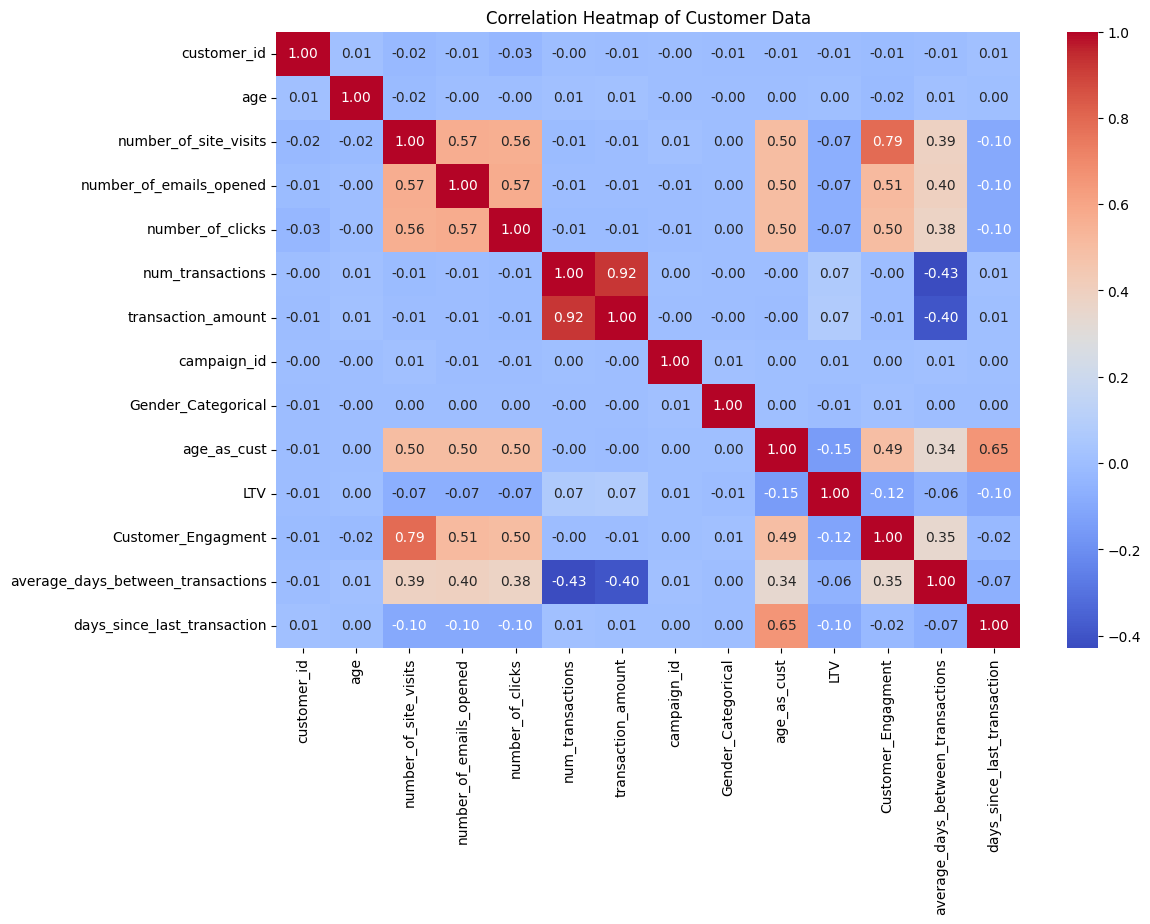

In [29]:
# Selecting only numerical columns for heatmap
numeric_cols = customer_data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = customer_data[numeric_cols].corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Customer Data')
plt.show()

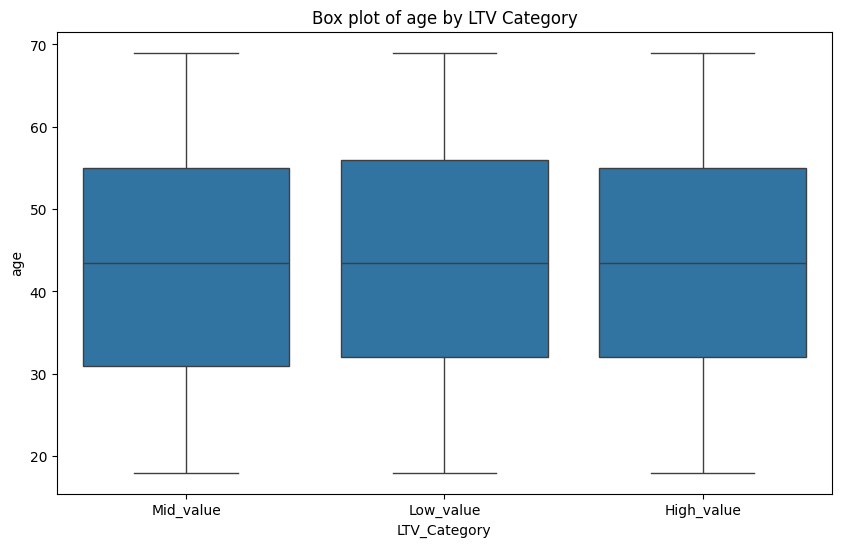

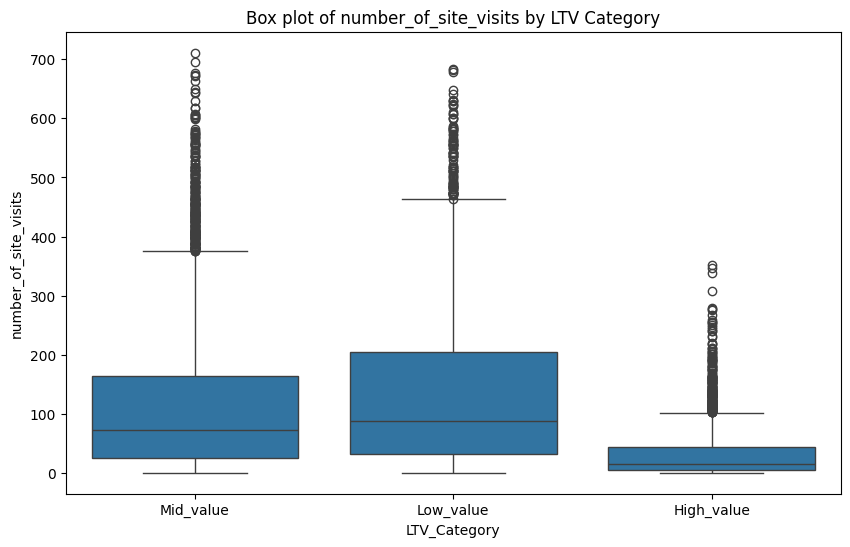

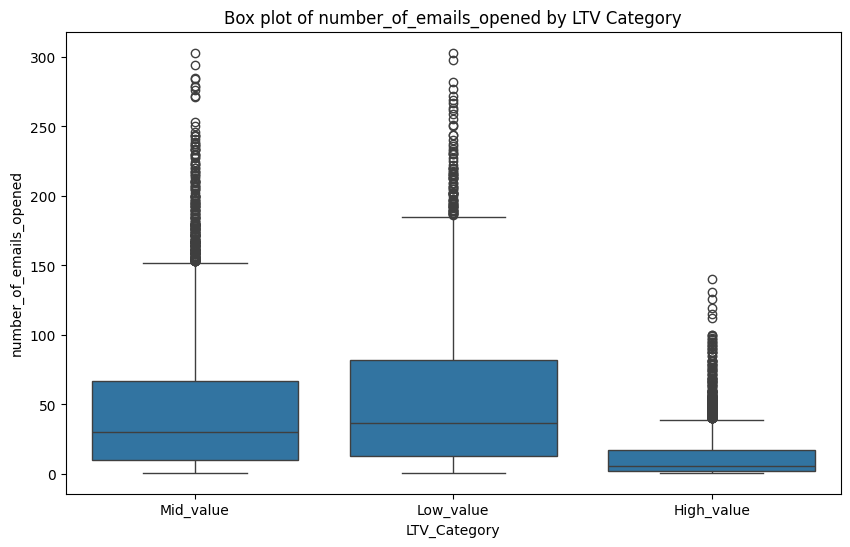

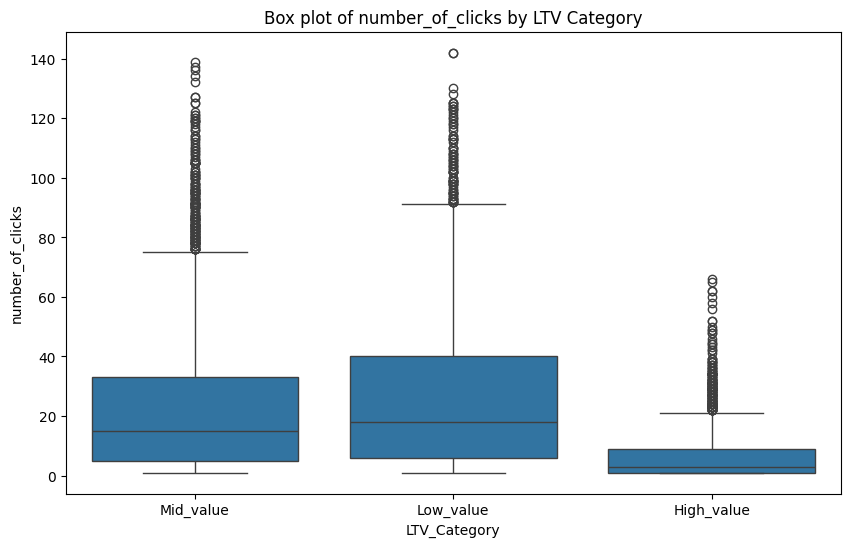

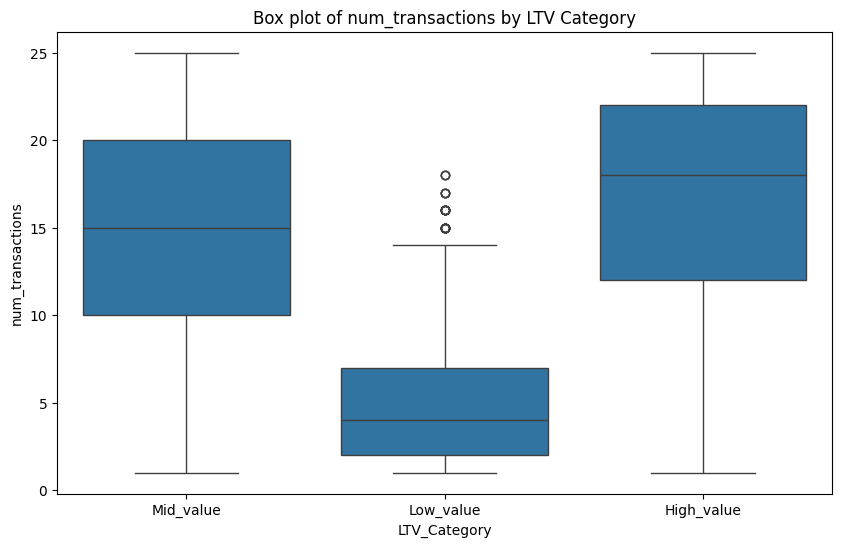

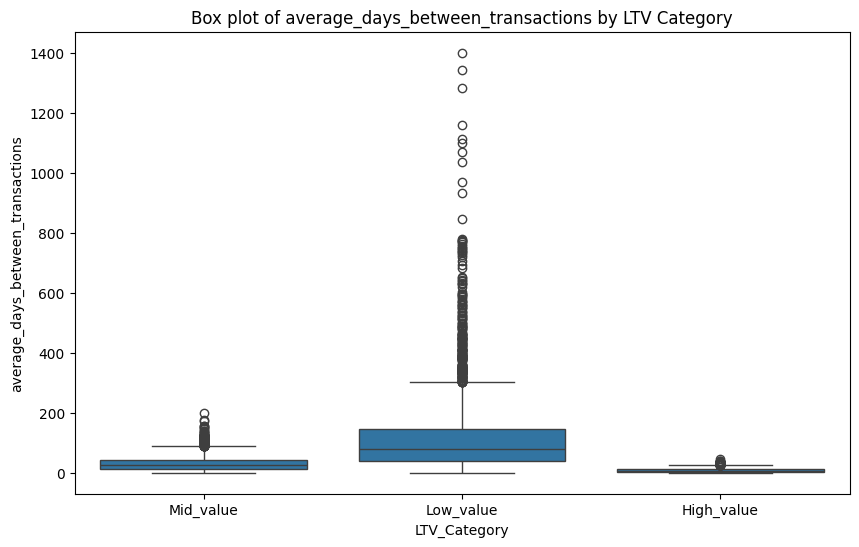

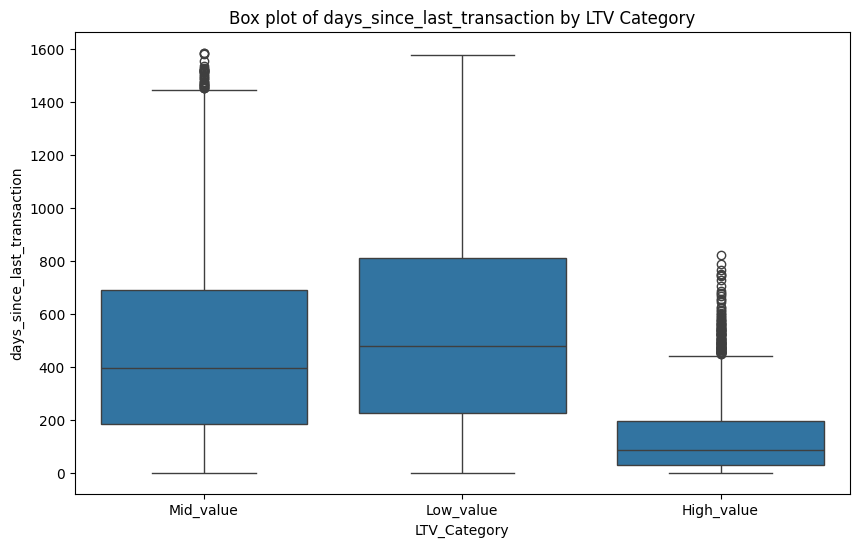

In [30]:
# Box plot for each numerical feature vs LTV category
# This helps to better see differences in behavior across LTV categories
numerical_features = ['age', 'number_of_site_visits', 'number_of_emails_opened', 
                      'number_of_clicks', 'num_transactions','average_days_between_transactions',
                'days_since_last_transaction']


for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='LTV_Category', y=feature, data=customer_data)
    plt.title(f'Box plot of {feature} by LTV Category')
    plt.show()

In [31]:


# Calculate gender distribution for each LTV category, this gives percentages
gender_distribution = customer_data.groupby(['LTV_Category','gender']).size().unstack(fill_value=0)
gender_distribution_percentage = gender_distribution.div(gender_distribution.sum(axis=1), axis=0) * 100
print(gender_distribution_percentage)

gender           Female       Male
LTV_Category                      
High_value    50.126582  49.873418
Low_value     49.348466  50.651534
Mid_value     49.512505  50.487495


In [32]:
# Calculate Customer Engagment breakdowns for each LTV category

gender_distribution = customer_data.groupby(['LTV_Category','Customer_Engagment']).size().unstack(fill_value=0)
gender_distribution_percentage = gender_distribution.div(gender_distribution.sum(axis=1), axis=0) * 100
print(gender_distribution_percentage)

Customer_Engagment      1      2      3
LTV_Category                           
High_value          49.36  46.96   3.68
Low_value           15.04  48.64  36.32
Mid_value           17.96  51.90  30.14


In [33]:
customer_data

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,num_transactions,transaction_amount,campaign_id,Gender_Categorical,age_as_cust,LTV,LTV_Category,Customer_Engagment,first_purchase_date,average_days_between_transactions,days_since_last_transaction
0,1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,1.0,1,0.528767,6637.099482,Mid_value,1,2024-01-09,11.333333,75
1,2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,2.0,2,2.728767,2228.596185,Mid_value,3,2021-09-29,84.000000,219
2,3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,3,3.000000,484.956667,Low_value,3,2021-09-28,70.833333,551
3,4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,1.0,2,2.413699,3262.495119,Mid_value,2,2022-01-11,11.650000,638
4,5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,0.0,2,2.350685,6604.266608,Mid_value,3,2022-03-02,19.041667,364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,2022-12-16,2023-08-13,42.000000,Female,Johnstonborough,119,47,16,10,5498.20,0.0,1,1.457534,3772.261278,Mid_value,2,2023-01-01,22.400000,292
9996,9997,2022-07-09,2023-01-25,26.000000,Male,Jessicamouth,3,33,14,12,5848.30,1.0,2,1.895890,3084.724711,Mid_value,1,2022-07-15,16.166667,492
9997,9998,2023-09-17,2024-01-30,39.000000,Male,New John,53,17,5,3,3503.13,1.0,2,0.704110,4975.262451,Mid_value,2,2023-11-13,26.000000,122
9998,9999,2022-05-10,2022-07-15,31.000000,Female,Andrewland,23,5,4,12,6721.86,0.0,1,2.060274,3262.604920,Mid_value,2,2022-05-24,4.333333,686


# Model


In [34]:
# Split data into X and y
X = customer_data[
    [
        'Customer_Engagment',
        'average_days_between_transactions',
        'days_since_last_transaction',
        'num_transactions'
    ]
]
y = customer_data['LTV_Category']

In [35]:
# Reserve 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=49)

In [36]:
# Ensure y_train is properly formatted (example assuming y_train is a column of labels)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Encode categorical labels if needed

In [37]:
# Define the models for testing
knn = KNeighborsClassifier()
nb = GaussianNB()


In [38]:
# Performing cross validation to determine in general which model works best for the given problem
knn_scores = cross_val_score(knn, X_train, y_train, scoring='f1_weighted', cv=5)
nb_scores = cross_val_score(nb, X_train, y_train, scoring='f1_weighted', cv=5)

print(np.mean(knn_scores))
print(np.mean(nb_scores))

0.8372975490360941
0.799185276220441


In [39]:
#Finding the best parameters for the KNN model
# Define the pipeline with scaling and KNeighborsClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

# Define the parameter grid for grid search
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Initialize Grid Search for KNN
grid_search_knn = GridSearchCV(estimator=pipeline, param_grid=param_grid_knn, cv=5, scoring='f1_weighted', n_jobs=-1)

# Fit the Grid Search to the data
grid_search_knn.fit(X_train, y_train_encoded)

# Print the best parameters and best score
print("Best Parameters for KNN:", grid_search_knn.best_params_)


Best Parameters for KNN: {'classifier__algorithm': 'auto', 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 11}


In [40]:
#Updating the KNN parameters
knn = KNeighborsClassifier(n_neighbors=11, metric='manhattan', algorithm = 'auto' )

In [41]:
# Fit the KNN model
knn.fit(X_train, y_train)


KNeighborsClassifier(metric='manhattan', n_neighbors=11)

In [42]:
# Predict on the test set
y_pred = knn.predict(X_test)

In [43]:
# Evaluate the model

f1 = f1_score(y_test,y_pred, average='weighted')
accuracy= accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics

print("f1", f1)
print("accuracy", accuracy)
print("precision", precision)
print("recall", recall)

f1 0.848865779740089
accuracy 0.8506666666666667
precision 0.8548606083906743
recall 0.8506666666666667


In [44]:
# Evaluate the model using classification_report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(report)

              precision    recall  f1-score   support

  High_value       0.90      0.88      0.89       742
   Low_value       0.89      0.71      0.79       763
   Mid_value       0.82      0.91      0.86      1495

    accuracy                           0.85      3000
   macro avg       0.87      0.83      0.85      3000
weighted avg       0.85      0.85      0.85      3000



# Marketing Info

In [45]:
# Merging customer_data with transactions on 'customer_id'
merged_data_1 = pd.merge(customer_data, transactions, on='customer_id', how='left')

# Merging the result with marketing data on 'customer_id'
merged_data_full = pd.merge(merged_data_1, marketing, on='customer_id', how='left')

# Creating a new dataframe with the needed columns
needed_columns = ['LTV_Category', 'promotion_type', 'product_category', 'response']
needed_df = merged_data_full[needed_columns]

In [46]:
needed_df

,LTV_Category,promotion_type,product_category,response
0,Mid_value,Buy One Get One,Clothing,No
1,Mid_value,Discount,Clothing,No
2,Mid_value,Free Shipping,Clothing,No
3,Mid_value,Buy One Get One,Clothing,Yes
4,Mid_value,Buy One Get One,Home Goods,No
...,...,...,...,...
327246,Mid_value,Discount,Electronics,Yes
327247,Mid_value,Free Shipping,Home Goods,No
327248,Mid_value,Discount,Home Goods,Yes
327249,Mid_value,Free Shipping,Home Goods,No


In [47]:
# Group by LTV_Category, promotion_type, and response, then calculate the size of each group

results=needed_df.groupby(['LTV_Category', 'promotion_type', 'response']).size().unstack()
print(results)

response                         No    Yes
LTV_Category promotion_type               
High_value   Buy One Get One  17595  19244
             Discount         18143  17126
             Free Shipping    17959  17576
Low_value    Buy One Get One   5409   5420
             Discount          5421   5577
             Free Shipping     5144   5616
Mid_value    Buy One Get One  30577  30494
             Discount         32128  31544
             Free Shipping    31640  30638


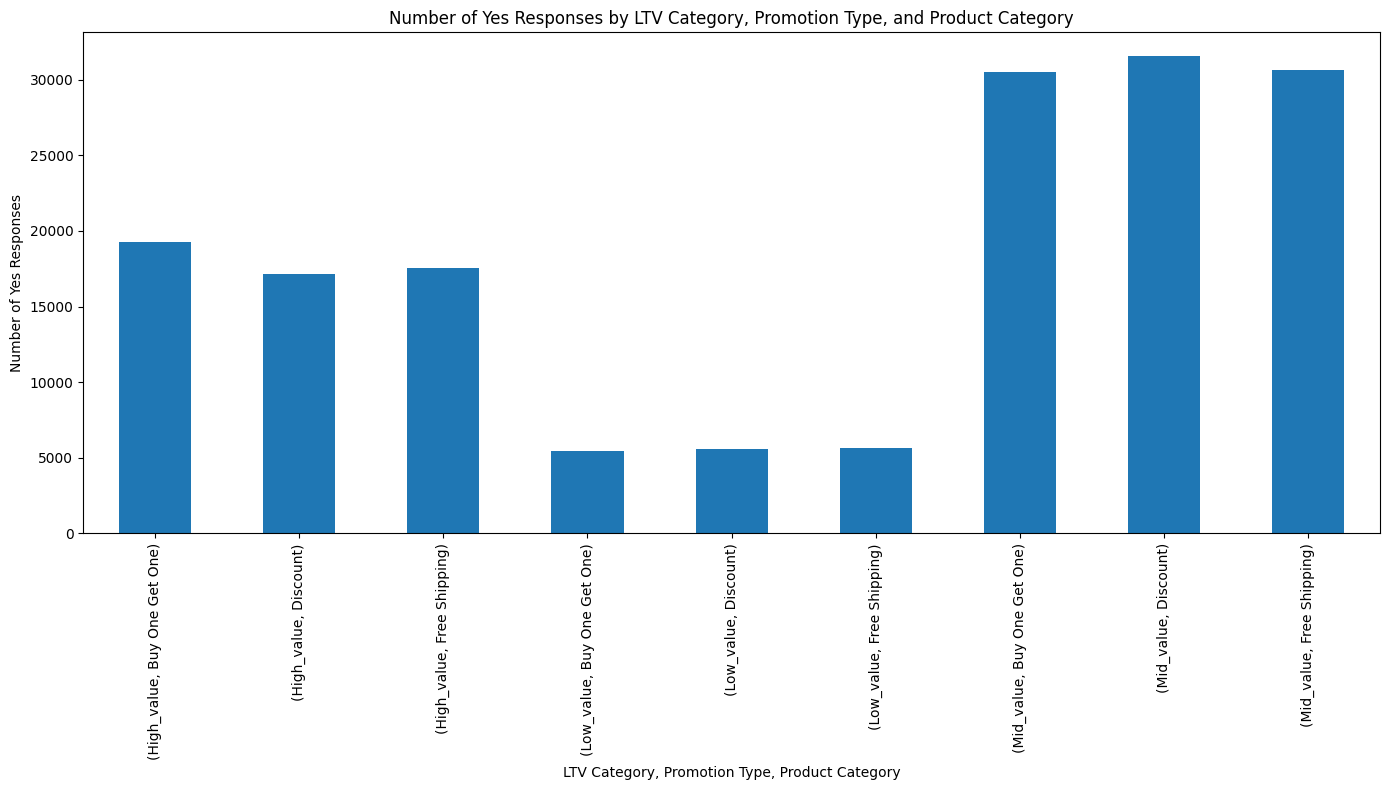

In [48]:
# Filter the data for only 'Yes' responses
yes_responses = results['Yes']

# Create the bar chart for 'Yes' responses
fig, ax = plt.subplots(figsize=(14, 8))

yes_responses.plot(kind='bar', ax=ax)

# Add title and labels
ax.set_title('Number of Yes Responses by LTV Category, Promotion Type, and Product Category')
ax.set_xlabel('LTV Category, Promotion Type, Product Category')
ax.set_ylabel('Number of Yes Responses')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

In [49]:

# Step 1: Group by LTV_Category, promotion_type, and response, and count occurrences
grouped_df = needed_df.groupby(['LTV_Category', 'promotion_type', 'response']).size().unstack()

# Step 2: Calculate percentages
percentages_df = grouped_df.div(grouped_df.sum(axis=1), axis=0) * 100

# Print the results
print(percentages_df)

response                             No        Yes
LTV_Category promotion_type                       
High_value   Buy One Get One  47.761883  52.238117
             Discount         51.441776  48.558224
             Free Shipping    50.538905  49.461095
Low_value    Buy One Get One  49.949210  50.050790
             Discount         49.290780  50.709220
             Free Shipping    47.806691  52.193309
Mid_value    Buy One Get One  50.067954  49.932046
             Discount         50.458600  49.541400
             Free Shipping    50.804457  49.195543
